In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import glob
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

In [3]:
from PreprocessingLabeledData import *
from AddingPredProbAndLabel2DF import *
from OverLapReturner import OverLapReturner
from SelectingBestNonOverlappingHits import *

In [4]:
%matplotlib inline

In [9]:
LabeledDataAddressDict = {}
LabeledDataAdds = sorted(glob.glob("../intermediates/*/*e0_labeled.tsv"))
DictOfAdds = {os.path.normpath(x).split(os.sep)[2]:x for x in LabeledDataAdds}
FullNameDict = {"Sc": "S. cerevisiae", "Ec":"E. coli","Mj":"M. jannaschii", "Tb":"T. brucei"}

In [12]:
AddressTbData = DictOfAdds["Tb"]
TbData = pd.read_csv(AddressTbData, sep="\t")
TbData = PreprocessingLabeledData(TbData)
LabeledData_tb = TbData[TbData["Status"]!=-1]
LabeledData_tb = LabeledData_tb.sample(frac=1, random_state=1).reset_index(drop=True)

X_tb = LabeledData_tb.values # The alignments of Tb will have a distinct naming convention
y_tb = LabeledData_tb['Status'].values # The alignments of Tb will have a distinct naming convention

In [13]:
totalNumAli = TbData.shape[0]
print("There are a total of {} possible alignments between Proteome of interest and Pfam instances".format(totalNumAli))
print("{} percent of the data is labeled as 1 ".format(LabeledData_tb[LabeledData_tb["Status"]==1].shape[0]*100/totalNumAli))
print("{} percent of the data is labeled as 0 ".format(LabeledData_tb[LabeledData_tb["Status"]==0].shape[0]*100/totalNumAli))

There are a total of 137440 possible alignments between Proteome of interest and Pfam instances
99.99927240977881 percent of the data is labeled as 1 
0.0 percent of the data is labeled as 0 


In [206]:
TbData.columns

Index(['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'lddt', 'FracOfPf', 'p_evalue', 'query', 'target',
       'qstart', 'qend', 'tstart', 'tend', 'qlen', 'PredPF', 'PF', 'PFstart',
       'PFend', 'evalue', 'Status'],
      dtype='object')

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X_tb, y_tb, train_size = 0.9, test_size=0.1, shuffle=False)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, train_size = 0.5, test_size=0.5, shuffle=False)

In [208]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
rf.fit(X_train[:,:9], y_train)

RandomForestClassifier(n_jobs=-1, random_state=1)

In [ ]:
#import joblib
#joblib.dump(rf, "./PFAS_RF.joblib", compress=3)

In [209]:
ModelDict = {}
TrainSizes = [0.01] #Add whatever fraction you want to test to this dictionary
ModelDict[1] = rf
for train_size in TrainSizes:
    X_train_frac, X_test_frac, y_train_frac, y_test_frac = train_test_split(X_train,y_train, train_size = train_size, test_size=1- train_size, shuffle=False)
    rf = RandomForestClassifier(n_estimators=100, criterion='gini', n_jobs=-1)
    rf.fit(X_train_frac[:,:9], y_train_frac)
    ModelDict[train_size] = rf


In [15]:
X_dict_orgs = {}
y_dict_orgs = {}

for org in ["Mj"]: #DictOfAdds:
    if org == "Tb":
        continue 
    Data = pd.read_csv(DictOfAdds[org], sep="\t")
    Data = PreprocessingLabeledData(Data)
    print("The summary of the alignments for {}".format(org))
    print("There are total of {} possible alignments between Proteome of {} and Pfam instances".format(Data.shape[0], org))
    totalNum = Data.shape[0]
    print("{} percent of the data is labeled 1 ".format(Data[Data["Status"]==1].shape[0]/totalNum*100))
    print("{} percent of the data is labeled 0 ".format(Data[Data["Status"]==0].shape[0]/totalNum*100))
    Data = Data[Data["Status"]!=-1]
    X_dict_orgs[org] = Data.values
    y_dict_orgs[org] = Data['Status'].values

The summary of the alignments for Mj
There are total of 313405 possible alignments between Proteome of Mj and Pfam instances
84.35506772387167 percent of the data is labeled 1 
15.6446132001723 percent of the data is labeled 0 


<Figure size 640x480 with 0 Axes>

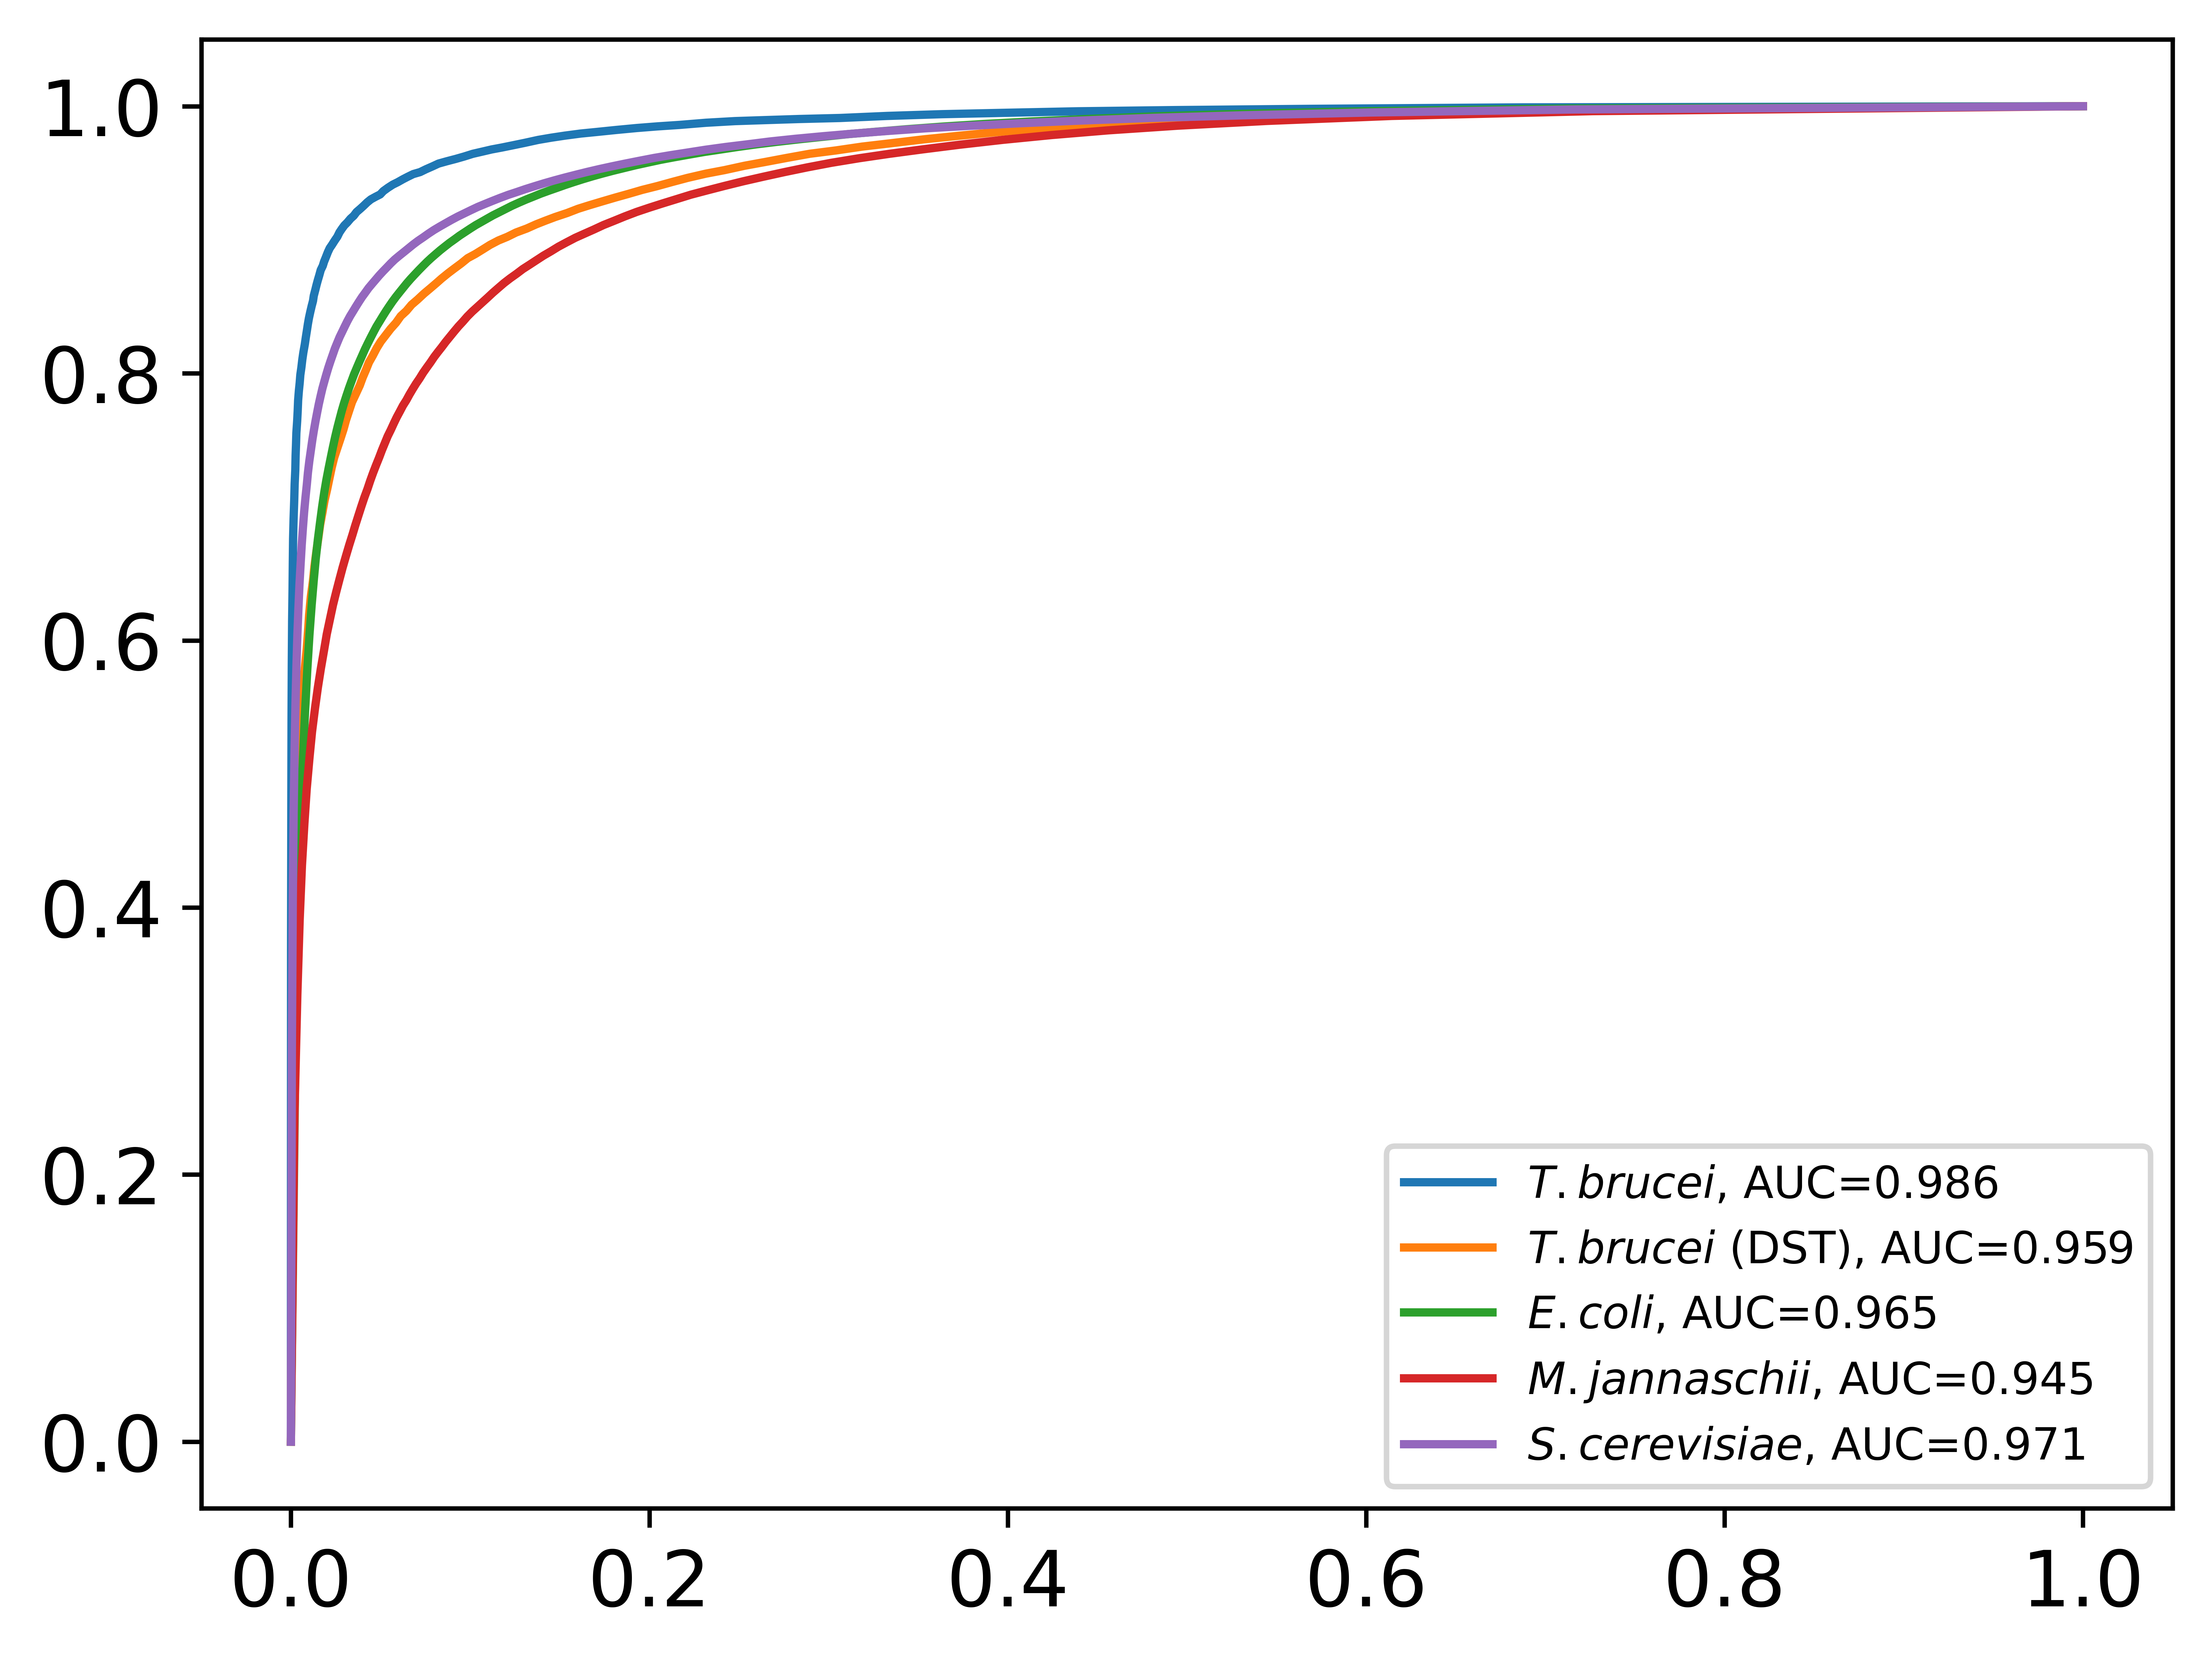

In [211]:
plt.figure(0).clf()
plt.figure(dpi=1200)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#add legend
#plt.legend()
ProbDict = {}

for frac in ModelDict.keys():
    model = ModelDict[frac]
    y_pred_prob = model.predict_proba(X_test[:,:9])[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    auc = round(metrics.roc_auc_score(y_test, y_pred_prob),3)
    if frac!= 1:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$ (DST)" +", AUC="+str(auc))
    else:
        plt.plot(fpr,tpr,label= "$\it{T. brucei}$" + ", AUC="+str(auc))
        ProbDict["Tb"] = y_pred_prob
   
model = ModelDict[1]
for org in X_dict_orgs.keys():
    y_pred_prob = model.predict_proba(X_dict_orgs[org][:,:9])[:, 1]
   
    fpr, tpr, _ = metrics.roc_curve(y_dict_orgs[org], y_pred_prob)
    auc = round(metrics.roc_auc_score(y_dict_orgs[org], y_pred_prob),3)
    plt.plot(fpr,tpr,label= "$\it{" + FullNameDict[org] + "}$" + ", AUC="+str(auc))
    ProbDict[org] = y_pred_prob

plt.legend( prop={'size': 8})

The following cell calculates the accuracy of the classifier on all alignments of each organism

In [262]:
def CalcAccuracy(df):
    CorrectNums = (df["PredLabel"]==df["Label"]).sum()
    SampleSize = df.shape[0]
    accuracy = CorrectNums/SampleSize
    return accuracy

def CalcAUC
metrics.roc_auc_score(y_test, y_pred_prob)

def MeanAccGroupedWise(df):
    return df.apply(lambda x: CalcAccuracy(x)).mean()
    
#from scipy.stats import binom
#def CalcPval(df, ACC):
#    CorrectNums = (df["PredLabel"]==df["Label"]).sum()
#    SampleSize = df.shape[0]
#    p_value = binom.cdf(CorrectNums,SampleSize,ACC)
#    return p_value

In [272]:
for org in DF_dict.keys():
    AllPreds = DF_dict[org]
    accuracy = CalcAccuracy(AllPreds)
    
    print("Accuraccy on {} is {}".format(org, accuracy))
    MAGBP = MeanAccGroupedWise(AllPreds.groupby("PF"))
    print("Mean accuracy on {} when data is grouped by the Pfam of the query is {}".format(org, MAGBP))
    MAGBPP  = MeanAccGroupedWise(AllPreds.groupby("PredPF"))
    print("Accuraccy on {} when data is grouped by the Pfam of the subject is {}".format(org, MAGBPP))
    
    

Accuraccy on Tb is 0.9457058069500781
Mean accuracy on Tb when data is grouped by the Pfam of the query is 0.919497389878292
Accuraccy on Tb when data is grouped by the Pfam of the subject is 0.9383315779508198
Accuraccy on Ec is 0.9074514563621819
Mean accuracy on Ec when data is grouped by the Pfam of the query is 0.9148751417132924
Accuraccy on Ec when data is grouped by the Pfam of the subject is 0.9132430554505893
Accuraccy on Mj is 0.884181746856443
Mean accuracy on Mj when data is grouped by the Pfam of the query is 0.8903850136117816
Accuraccy on Mj when data is grouped by the Pfam of the subject is 0.8966679690853738
Accuraccy on Sc is 0.9188611567777611
Mean accuracy on Sc when data is grouped by the Pfam of the query is 0.9226650988731305
Accuraccy on Sc when data is grouped by the Pfam of the subject is 0.9285288038755822


# Best hit attribution benchmarking
The next part is for Evaluating Best Hit attribution, first, we have to predict the probability and the label of each alignment by the trained model, then select the best hit, and continue annotating new domain to the point each newly added domain overlaps less than 10 aminoacids with previously added domains.

In [278]:
#This block is for retrieving the number of annotated Pfams for each organism
PfamAnnotationNums = {}
for org in FullNameDict.keys():
    file = open("../rawinput/{}/Pfam{}.txt".format(org,org))
    NumOfAnnotations = len(file.read().strip().split("\n"))
    PfamAnnotationNums[org] = NumOfAnnotations
    

The next block is for retrieving the Proteins in each organism among the Pfam Seeds


In [296]:
PfamSeedsDict = {}
for org in FullNameDict.keys():
    PfamSeedsInOrg = open("../rawinput/{}/PfamSeeds{}.tsv".format(org,org)).read().strip().split("\n")
    PfamSeedsDict[org] = PfamSeedsInOrg

In [280]:
def Precision(df):
    TotalPreds = df.shape[0]
    CorrectPreds = df[df["Status"]==1].shape[0]
    return CorrectPreds/TotalPreds
def Sensitivity(df, org):
    correctAnns = df[df["Status"]==1]
    return correctAnns.shape[0]/PfamAnnotationNums[org]

In [275]:
model = ModelDict[1]
PrecisionDict = {}
AnnotDict = {}
AnnotDFTb = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_tb, model))
AnnotDict["Tb"] = AnnotDFTb

for org in X_dict_orgs.keys():
    AnnotDF = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_dict_orgs[org], model))
    AnnotDict[org] = AnnotDF

In [302]:
for org in AnnotDict.keys():
    annots = AnnotDict[org]
    TruePreds = annots[annots["Status"]==1] 
    print("information on {}".format(org))
    print("{} percent of Annotated Pfams have been correctly annotated".format(100* Precision(annots)))
    print("{} percent of Annotated Pfams have been retrieved correctly".format(100* Sensitivity(annots, org)))
    print("When considering those not among the Pfam Seeds:")
    NotSeedsDF = annots[~annots["query"].isin(PfamSeedsDict[org])]
    print("{} percent of Annotated Pfams have been correctly annotated".format(100* Precision(NotSeedsDF)))
    print("{} percent of Annotated Pfams have been retrieved correctly".format(100* Sensitivity(NotSeedsDF, org)))
    

information on Tb
99.32596891967796 percent of Annotated Pfams have been correctly annotated
79.36864153201675 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
99.16782246879335 percent of Annotated Pfams have been correctly annotated
53.48593656493118 percent of Annotated Pfams have been retrieved correctly
information on Ec
97.34126290012244 percent of Annotated Pfams have been correctly annotated
90.03397508493771 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
96.55172413793103 percent of Annotated Pfams have been correctly annotated
40.31710079275198 percent of Annotated Pfams have been retrieved correctly
information on Mj
95.67076429716728 percent of Annotated Pfams have been correctly annotated
83.99812294697325 percent of Annotated Pfams have been retrieved correctly
When considering those not among the Pfam Seeds:
92.3913043478261 percent of Annotated Pfams have 

In [310]:
for org in FullNameDict.keys():
    PfamAnns = pd.read_csv("../rawinput/{}/Pfam{}.txt".format(org, org),sep="\t", header=None)
    print("The number of total annotations for {} is {}".format(org,PfamAnns.shape[0] ))
    NotSeeds = PfamAnns[~PfamAnns[0].isin(PfamSeedsDict[org])]
    print("The number of annotations for proteins not among Pfam Seeds of {} is {}".format(org,NotSeeds.shape[0] ))

The number of total annotations for Sc is 7924
The number of annotations for proteins not among Pfam Seeds of Sc is 3550
The number of total annotations for Ec is 6181
The number of annotations for proteins not among Pfam Seeds of Ec is 2824
The number of total annotations for Mj is 2131
The number of annotations for proteins not among Pfam Seeds of Mj is 648
The number of total annotations for Tb is 6684
The number of annotations for proteins not among Pfam Seeds of Tb is 4622


In [284]:
model = ModelDict[1]
FeatureImps = model.feature_importances_
FeatureNames = ['fident', 'alnlen', 'nmismatch', 'ngapopen', 'pflen', 'bit score', 'TM-score','lddt', "pfcov"]
SortedFeatures = sorted(zip(FeatureNames, FeatureImps), key=lambda x: x[1], reverse=True)
for item in SortedFeatures:
    print(item[0] + "\t"+ str(item[1]))

lddt	0.23479133605539054
bit score	0.18051206731326025
fident	0.1452471665854542
ngapopen	0.11239563216432527
TM-score	0.08559345580191974
pflen	0.08459688459140655
alnlen	0.06642874627498845
pfcov	0.04662580530476597
nmismatch	0.04380890590848916


# Annotating New Genes in T. brucei

In [223]:
exec(open("AddingPredProbAndLabel2DF.py").read())
exec(open("PreprocessingLabeledData.py").read())
exec(open("SelectingBestNonOverlappingHits.py").read())

In [224]:
PfamAnnDict = {}
PfamsTb = open("../rawinput/Tb/PfamTb.txt")
for line in PfamsTb:
    Gene, Pf, start,end = line.strip().split()
    Intervals = PfamAnnDict.get(Gene, [])
    Intervals.append((int(start), int(end)))
    PfamAnnDict[Gene] = Intervals

In [225]:
X_to_check_Tb = TbData[TbData["Status"]==-1].values

In [226]:
model = ModelDict[1]
NewlyAnn = SelectingBestNonOverlappingHits(AddingPredProbAndLabel2DF(X_to_check_Tb, model), PfamAnnDict)

In [227]:
NewlyAnn.columns

Index(['fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'lddt', 'FracOfPf', 'p_evalue', 'query', 'target',
       'qstart', 'qend', 'tstart', 'tend', 'qlen', 'PredPF', 'PF', 'PFstart',
       'PFend', 'evalue', 'Status', 'PredLabel', 'RF_prob'],
      dtype='object')

In [228]:
NewlyAnn.columns
NewlyAnn = NewlyAnn[['query', 'PredPF', 'qstart', 'qend', 'RF_prob','target', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'FracOfPf', 'p_evalue',  'tstart',
       'tend', 'qlen', 'PF', 'PFstart', 'PFend',
       'evalue', 'Status', 'PredLabel']]
NewlyAnn = NewlyAnn[['query', 'PredPF', 'qstart', 'qend', 'RF_prob','target', 'fident', 'alnlen', 'MismatchRatio', 'GapOpenRatio', 'tlen', 'bits',
       'alntmscore', 'FracOfPf', 'p_evalue',  'tstart',
       'tend', 'qlen']]

In [229]:
NewlyAnn.columns = ['Query', 'PredPF', 'Qstart', 'Qend', 'RF_prob','PFinstance', 'fident', 'alnlen', 'nmismatch', 'ngapopen', 'PFlen', 'bit score',
       'alntmscore', 'pfcov', 'p_evalue',  'InstanceStart',
       'InstanceEnd', 'Qlen']

In [234]:
NewlyAnn.to_csv("../predictions/NewPredictionsTb_AgPfam_e2_without_e_value.txt", index=None, sep="\t")

In [32]:
NewlyAnn.groupby(['PredPF'])['PredPF'].count().sort_values(ascending=False)[:10]

PredPF
PF13458    72
PF12799    50
PF00400    41
PF00913    31
PF00560    30
PF00076    29
PF12894    20
PF01762    19
PF14783    19
PF00225    16
Name: PredPF, dtype: int64